## Cell Counting

Primary notebook for cell counting efforts that involves 3 primary steps:

1. Select training, validation and un-annotated data
2. Train model and freeze weights in persisted location
3. Load model and apply to un-annotated data

In [1]:
%run config02.py
%matplotlib inline

import os
import os.path as osp
import warnings
import numpy as np
import pandas as pd
import papermill as pm
import matplotlib.pyplot as plt
from mrcnn import visualize as mrcnn_viz
from mrcnn import model as mrcnn_model_lib
from cvutils.rectlabel import io as rectlabel_io
from cvutils.mrcnn import model as mrcnn_model
from cvutils.mrcnn.session import init_keras_session
from celldom import dataset as celldom_dataset
from celldom import seed
init_keras_session()

run_name = '201805'
dataset_name = 'dataset02'

# Use first dataset provided (about ~30 annotated images)
data_dir = osp.join(os.environ['CELLDOM_DATA_DIR'], 'data', dataset_name)

# Location for trained models and results
model_dir = osp.join('models', 'cell_counting_training', run_name)
export_dir = osp.join('results', 'cell_counting_training', run_name)

# Initialize output directories
os.makedirs(export_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Show class names being used for training
CLASS_NAMES

['Cell',
 'StNum',
 'AptNum',
 'CellClump',
 'Marker',
 'Chamber',
 'Trap',
 'Channel']

## Data Partitioning

The purpose of this section is to establish training, validation, and external partitions of the configured dataset.  Generally, all annotated data up to a specific portion of the dataset will be used for training or validation and any non-annotated images or images w/ bad or inconsistent annotations will become "external" (i.e. used only for applications of the model):

In [3]:
# Determine all available images for training
data_files = celldom_dataset.get_data_files(data_dir)

# Ensure there are no duplicate image entries
if len(data_files) > 0:
    assert data_files['image_name'].value_counts().max() == 1

print(
    'Number of images total = {}, number annotated = {}'
    .format(len(data_files), data_files.annot_exists.sum())
)
data_files.head(3)

Number of images total = 824, number annotated = 160


,image_name,image_path,annot_path,annot_exists
444,BF_ST_000_APT_000Day0.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,/lab/data/celldom/data/dataset02/annotations/B...,True
417,BF_ST_000_APT_000Day1.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,/lab/data/celldom/data/dataset02/annotations/B...,True
352,BF_ST_000_APT_000Day2.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,/lab/data/celldom/data/dataset02/annotations/B...,True


In [4]:
# Compute summary statistics about images to help determine the status of each
data_files = celldom_dataset.quantify_data_files(data_files, CLASS_NAMES)
data_files[data_files.annot_exists].head()

,annot_exists,annot_path,ct:aptnum,ct:cell,ct:cellclump,ct:chamber,ct:channel,ct:marker,ct:stnum,ct:trap,image_name,image_path,pct:cell_to_cellclump
444,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,3.0,2.0,1.0,2.0,1.0,1.0,1.0,BF_ST_000_APT_000Day0.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,1.000000
417,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,14.0,1.0,1.0,2.0,1.0,1.0,1.0,BF_ST_000_APT_000Day1.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,0.954879
352,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,31.0,1.0,1.0,2.0,1.0,1.0,1.0,BF_ST_000_APT_000Day2.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,0.968886
142,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,86.0,2.0,1.0,2.0,1.0,1.0,1.0,BF_ST_000_APT_000Day3.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,0.874408
191,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,BF_ST_000_APT_001Day0.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,1.000000


In [5]:
data_files['pct:cell_to_cellclump'].describe()

count    144.000000
mean       0.950697
std        0.111018
min        0.148410
25%        0.942364
50%        0.969786
75%        1.000000
max        1.000000
Name: pct:cell_to_cellclump, dtype: float64

In [6]:
PCT_CELL_TO_CELLCLUMP_THRESH = .8

def get_exclusion_reason(r):
    if not r['annot_exists']:
        return 'No Annotations'
    for c in EXPECTED_CLASS_COUNTS.keys():
        if r['ct:' + c.lower()] != EXPECTED_CLASS_COUNTS[c]:
            return '{} Count != {}'.format(c, EXPECTED_CLASS_COUNTS[c])
    if not pd.isnull(r['pct:cell_to_cellclump']) and r['pct:cell_to_cellclump'] < PCT_CELL_TO_CELLCLUMP_THRESH:
        return 'Cell to Clump Ratio < {}'.format(PCT_CELL_TO_CELLCLUMP_THRESH)
    return None

data_files['exclusion'] = data_files.apply(get_exclusion_reason, axis=1)
data_files[data_files.exclusion.notnull() & data_files.annot_exists].head()

,annot_exists,annot_path,ct:aptnum,ct:cell,ct:cellclump,ct:chamber,ct:channel,ct:marker,ct:stnum,ct:trap,image_name,image_path,pct:cell_to_cellclump,exclusion
768,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,21.0,1.0,1.0,2.0,1.0,1.0,1.0,BF_ST_000_APT_004Day2.jpg,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,0.775991,Cell to Clump Ratio < 0.8
158,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,5.0,0.0,1.0,0.0,1.0,1.0,0.0,BF_ST_001_APT_000Day0.jpg,/lab/data/celldom/data/dataset02/BF_ST_001_APT...,NaN,Channel Count != 2
690,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,8.0,1.0,1.0,0.0,1.0,1.0,0.0,BF_ST_001_APT_000Day1.jpg,/lab/data/celldom/data/dataset02/BF_ST_001_APT...,0.985799,Channel Count != 2
27,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,19.0,2.0,1.0,0.0,1.0,1.0,0.0,BF_ST_001_APT_000Day2.jpg,/lab/data/celldom/data/dataset02/BF_ST_001_APT...,0.856643,Channel Count != 2
242,True,/lab/data/celldom/data/dataset02/annotations/B...,1.0,55.0,1.0,1.0,0.0,1.0,1.0,0.0,BF_ST_001_APT_000Day3.jpg,/lab/data/celldom/data/dataset02/BF_ST_001_APT...,0.946922,Channel Count != 2


In [7]:
data_files.exclusion.isnull().value_counts()

False    719
True     105
Name: exclusion, dtype: int64

In [8]:
data_files.exclusion.value_counts()

No Annotations               664
Channel Count != 2            46
Trap Count != 1                5
Cell to Clump Ratio < 0.8      4
Name: exclusion, dtype: int64

In [9]:
MODELING_MAX_SAMPLES = 150
TRAINING_FRACTION = .8

# Determine index corresponding to first MODELING_MAX_SAMPLES records eligible for model (as training or validation records)
idx_modeling = data_files[data_files.exclusion.isnull()].head(MODELING_MAX_SAMPLES).index.values

# Split index into training and validation 
idx_train = pd.Series(idx_modeling).sample(frac=TRAINING_FRACTION, random_state=seed).values
idx_val = np.setdiff1d(idx_modeling, idx_train)

data_files['group'] = 'external'
data_files.loc[idx_train, 'group'] = 'training'
data_files.loc[idx_val, 'group'] = 'validation'

# Summarize and verify counts by training record group
grp_ct = data_files['group'].value_counts()
assert grp_ct['training'] + grp_ct['validation'] == data_files.exclusion.isnull().sum()
assert grp_ct['external'] == data_files.exclusion.notnull().sum()
data_files['group'].value_counts()

external      719
training       84
validation     21
Name: group, dtype: int64

In [10]:
# Save record of data file categorization for later reference
path = osp.join(export_dir, 'data_files.csv')
data_files.to_csv(path, index=False)
'Data file metadata saved to path {}'.format(path)

'Data file metadata saved to path results/cell_counting_training/201805/data_files.csv'

## Training

Based on the file categorization above, this section will use all available training + validation data to build a segmentation model:

In [11]:
# Training dataset
train_image_paths = data_files.groupby('group').get_group('training')['image_path'].values
dataset_train = celldom_dataset.CelldomDataset()
dataset_train.initialize(train_image_paths, CLASS_NAMES)
dataset_train.prepare()

# # Validation dataset
val_image_paths = data_files.groupby('group').get_group('validation')['image_path'].values
dataset_val = celldom_dataset.CelldomDataset()
dataset_val.initialize(val_image_paths, CLASS_NAMES)
dataset_val.prepare()

'Num training images = {}, num validation images = {}'.format(len(train_image_paths), len(val_image_paths))

'Num training images = 84, num validation images = 21'

In [12]:
# Fetch RCNN training configuration
train_config = CelldomTrainingConfig()

# Set these step counts to equal data size so that a single epoch is easier to describe
train_config.STEPS_PER_EPOCH = len(train_image_paths)
train_config.VALIDATION_STEPS = len(val_image_paths)
    
train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        250
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               250
MEAN_PIXEL                     [123.7 116.8 103.9]
MIN

In [13]:
# Initialize model from COCO weights (change to "last" to restart from last training run)
model = mrcnn_model.get_model(mode="training", config=train_config, model_dir=model_dir, init_with='coco')

In [ ]:
# Ignore these warnings for now as they seem to be irrelevant
warnings.filterwarnings(
    'ignore', category=UserWarning,
    message='Converting sparse IndexedSlices to a dense Tensor of unknown shape'
)
warnings.filterwarnings(
    'ignore', category=UserWarning,
    message='Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data'
)

# Run training for small number of epochs (takes about 1 min per epoch on this dataset)
n_epochs = 40
model.train(
    dataset_train, dataset_val, 
    learning_rate=train_config.LEARNING_RATE, 
    epochs=n_epochs, 
    layers='heads'
)


Starting at epoch 0. LR=0.001

Checkpoint Path: models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed

- Check tensorboard
- Pick epoch to use moving forward and copy to results dir

In [15]:
!find $model_dir/* | sort

models/cell_counting_training/201805/celldom20180530T1145
models/cell_counting_training/201805/celldom20180530T1145/events.out.tfevents.1527680747.71e9bb78d73c
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0001.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0002.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0003.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0004.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0005.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0006.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0007.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0008.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0009.h5
models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0010.h5


In [50]:
model_path = osp.join(export_dir, 'cell_counting_model.h5')
!cp models/cell_counting_training/201805/celldom20180530T1145/mask_rcnn_celldom_0015.h5 $model_path
'Final model copied to result path "{}"'.format(model_path)

'Final model copied to result path "results/cell_counting_training/201805/cell_counting_model.h5"'

## Check Validation Predictions

In [67]:
from cvutils.mrcnn import inference as mrcnn_inference
from celldom import inference as celldom_inference

# Re-initialize model from exported weights in inference mode
inference_config = CelldomInferenceConfig()
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

# Generate prediction comparisons
pred_gen = mrcnn_inference.prediction_generator(model, dataset_val)
analysis_fns = celldom_inference.get_default_analysis_fns()
df = pd.DataFrame([celldom_inference.analyze_prediction(p, analysis_fns) for p in pred_gen])
df.head()

,counts,image_id,image_info,scores_aptnum,scores_cell,scores_cellclump,scores_cellunion,scores_chamber,scores_stnum,stats_cell,stats_cellclump,stats_cellunion,stats_chamber
0,"{'pred': [17, 2, 1, 1, 1, 1, 1, 1], 'true': [1...",0,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,"{'jaccard': 0.9938083224826388, 'pred_status':...","{'jaccard': 0.9961886935763888, 'pred_status':...","{'jaccard': 0.99407958984375, 'pred_status': '...","{'jaccard': 0.9956393771701388, 'pred_status':...","{'jaccard': 0.98858642578125, 'pred_status': '...","{'jaccard': 0.9957071940104166, 'pred_status':...","{'pred': [17.0, 268.5882352941176, 70.89433935...","{'pred': [1.0, 4032.0, nan, 4032.0, 4032.0, 40...","{'pred': [1.0, 4148.0, nan, 4148.0, 4148.0, 41...","{'pred': [1.0, 38264.0, nan, 38264.0, 38264.0,..."
1,"{'pred': [28, 2, 2, 1, 1, 1, 1, 1], 'true': [2...",1,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,"{'jaccard': 0.9945271809895834, 'pred_status':...","{'jaccard': 0.9899495442708334, 'pred_status':...","{'jaccard': nan, 'pred_status': 'Multiple', 't...","{'jaccard': nan, 'pred_status': 'Valid', 'true...","{'jaccard': 0.9869316948784722, 'pred_status':...","{'jaccard': 0.9964463975694444, 'pred_status':...","{'pred': [28.0, 256.89285714285717, 119.873803...","{'pred': [2.0, 3566.0, 4533.9686809681425, 360...","{'pred': [1.0, 6162.0, nan, 6162.0, 6162.0, 61...","{'pred': [1.0, 37955.0, nan, 37955.0, 37955.0,..."
2,"{'pred': [92, 2, 2, 1, 1, 1, 1, 1], 'true': [8...",2,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,"{'jaccard': 0.9939982096354166, 'pred_status':...","{'jaccard': 0.98309326171875, 'pred_status': '...","{'jaccard': nan, 'pred_status': 'Multiple', 't...","{'jaccard': nan, 'pred_status': 'Valid', 'true...","{'jaccard': 0.9799669053819444, 'pred_status':...","{'jaccard': 0.9929945203993056, 'pred_status':...","{'pred': [92.0, 267.14130434782606, 201.561191...","{'pred': [2.0, 9712.5, 13476.74814263441, 183....","{'pred': [1.0, 19607.0, nan, 19607.0, 19607.0,...","{'pred': [1.0, 36674.0, nan, 36674.0, 36674.0,..."
3,"{'pred': [13, 2, 2, 1, 1, 1, 1, 1], 'true': [1...",3,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,"{'jaccard': 0.9948662651909722, 'pred_status':...","{'jaccard': 0.9965142144097222, 'pred_status':...","{'jaccard': nan, 'pred_status': 'Multiple', 't...","{'jaccard': nan, 'pred_status': 'Valid', 'true...","{'jaccard': 0.9871012369791666, 'pred_status':...","{'jaccard': 0.9960055881076388, 'pred_status':...","{'pred': [13.0, 252.15384615384616, 59.2745675...","{'pred': [2.0, 1539.0, 1873.8329701443508, 214...","{'pred': [1.0, 3075.0, nan, 3075.0, 3075.0, 30...","{'pred': [1.0, 38336.0, nan, 38336.0, 38336.0,..."
4,"{'pred': [35, 2, 1, 1, 1, 1, 1, 1], 'true': [3...",4,/lab/data/celldom/data/dataset02/BF_ST_000_APT...,"{'jaccard': 0.9939914279513888, 'pred_status':...","{'jaccard': 0.9913669162326388, 'pred_status':...","{'jaccard': 0.9906887478298612, 'pred_status':...","{'jaccard': 0.9886338975694444, 'pred_status':...","{'jaccard': 0.9876030815972222, 'pred_status':...","{'jaccard': 0.9952053493923612, 'pred_status':...","{'pred': [35.0, 237.25714285714287, 55.8502950...","{'pred': [1.0, 8384.0, nan, 8384.0, 8384.0, 83...","{'pred': [1.0, 7495.0, nan, 7495.0, 7495.0, 74...","{'pred': [1.0, 38064.0, nan, 38064.0, 38064.0,..."


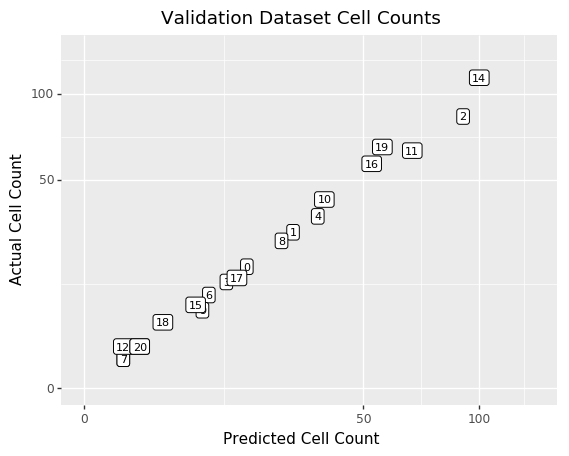

<ggplot: (8789984748457)>

In [72]:
import plotnine as pn
(
    pn.ggplot(
        pd.DataFrame([
            (r['image_id'], r['counts']['pred'].get('Cell', 0), r['counts']['true'].get('Cell', 0))
            for i, r in df.iterrows()
        ], columns=['id', 'pred', 'true']),
        pn.aes(x='pred', y='true', label='id')
    ) + 
    pn.xlab('Predicted Cell Count') +
    pn.ylab('Actual Cell Count') +
    pn.scale_x_sqrt(limits=(0, 130)) + pn.scale_y_sqrt(limits=(0, 130)) +
    pn.ggtitle('Validation Dataset Cell Counts') +
    pn.geom_label(size=8)
)

Processing 1 images
image                    shape: (384, 384, 3)         min:    0.00000  max:  252.00000  uint8
molded_images            shape: (1, 384, 384, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max:  384.00000  int64
anchors                  shape: (1, 36828, 4)         min:   -0.23632  max:    1.06922  float32


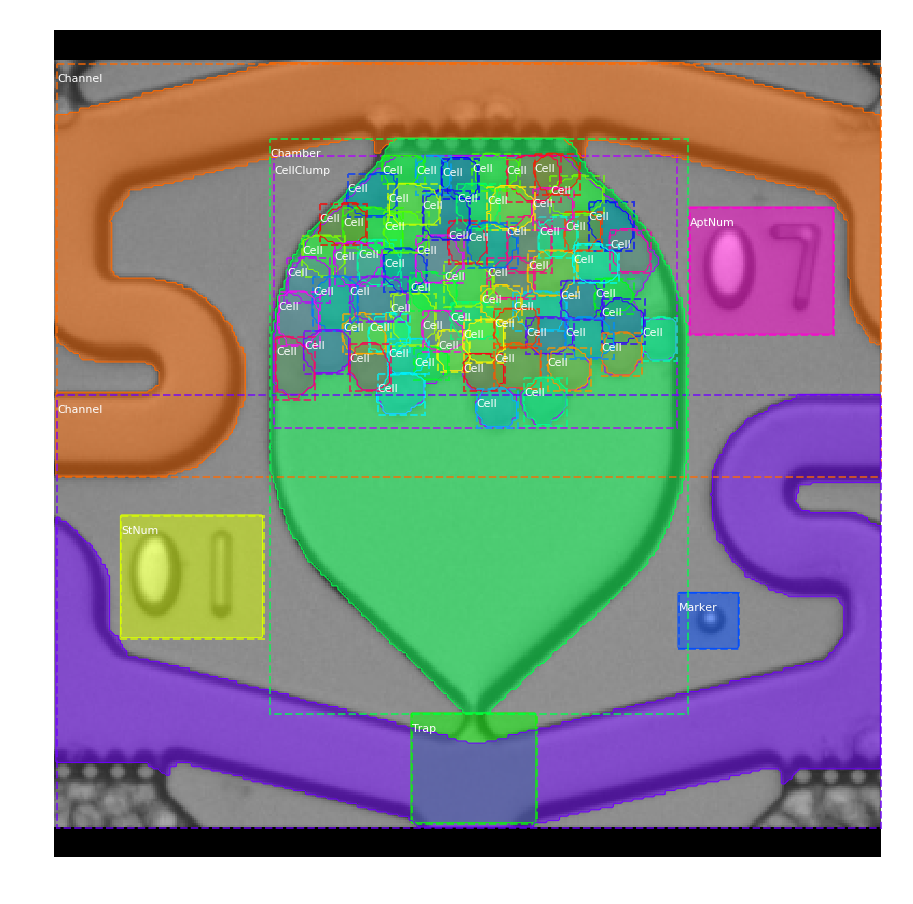

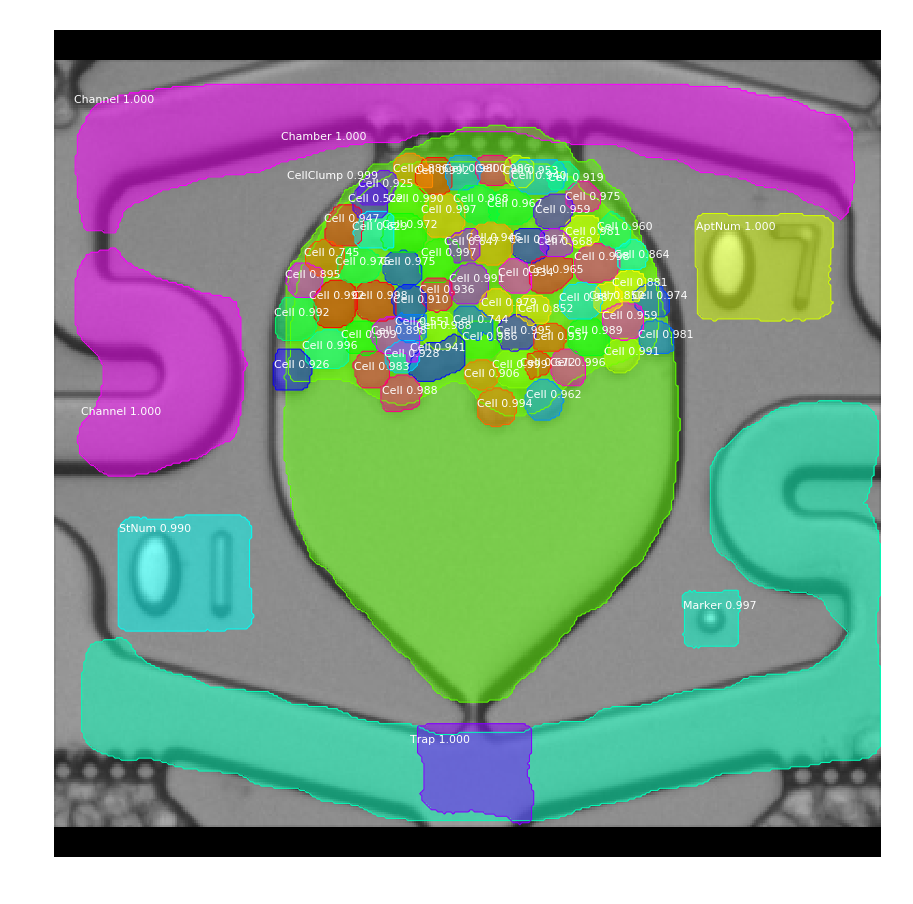

In [71]:
image_id = 11
image, image_meta, gt_class_id, gt_bbox, gt_mask = mrcnn_model_lib.load_image_gt(
    dataset_val, inference_config, image_id, use_mini_mask=False)
r = model.detect([image], verbose=1)[0]
mrcnn_viz.display_instances(image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(16, 16))
mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], show_bbox=False)